In [1]:
import os
import pandas as pd
import numpy as np
import lightgbm
from collections import Counter

Read the training and test data

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df  = pd.read_csv("data/test.csv")

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
#extract cabin letters and numbers
def feature_extraction(df):
    def get_surname(x):
        return x['Name'].apply(lambda x: x.split(',')[0])
    def get_prefix(x):
        return x['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    def firstname_split(x):
        res = x.split(',')[1].split('.')[1].strip().split(' ')[0]
        return res.replace('(', '').replace(')', '')
    def get_firstname(x):
        return x['Name'].apply(firstname_split)
    def extract_cabin_letter(x):
        if x is np.nan: 
            return ''
        else: 
            return x[0].upper()
    def extract_cabin_num(x):
        if x is np.nan: 
            return ''
        else: 
            return x[1:]
    def get_ticket_pre(x):
        #if it is int, then this is actually the ticket number so ignore for next function
        res = x.split(' ')[0]
        try:
            res = int(res)
            return ''
        except:
            return res
    def get_ticket_num(x):
        res = x.split(' ')[-1]
        return res
    df['Cabin_L']   = df['Cabin'].apply(extract_cabin_letter)
    df['Cabin_N']   = df['Cabin'].apply(extract_cabin_num)
    df['Surname']   = get_surname(df)
    df['Prefix']    = get_prefix(df)
    df['Firstname'] = get_firstname(df)
    df['Ticket_C']  = df['Ticket'].apply(get_ticket_pre)
    df['Ticket_N']  = df['Ticket'].apply(get_ticket_num)
    df['Ticket_Level'] = df['Ticket_N'].apply(lambda x: x[0])

    return df

In [30]:
train_df = feature_extraction(train_df)
test_df = feature_extraction(test_df)

In [6]:
train_df[train_df.isna().any(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_L,Cabin_N,Surname,Prefix,Firstname,Ticket_C,Ticket_N
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,,,Braund,Mr,Owen,A/5,21171
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,,,Heikkinen,Miss,Laina,STON/O2.,3101282
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,,,Allen,Mr,William,,373450
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,,,Moran,Mr,James,,330877
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,,,Palsson,Master,Gosta,,349909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,,,Sutehall,Mr,Henry,SOTON/OQ,392076
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,,,Rice,Mrs,William,,382652
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,,,Montvila,Rev,Juozas,,211536
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,,,Johnston,Miss,Catherine,W./C.,6607


In [7]:
Counter(train_df['Prefix'])

Counter({'Mr': 517,
         'Mrs': 125,
         'Miss': 182,
         'Master': 40,
         'Don': 1,
         'Rev': 6,
         'Dr': 7,
         'Mme': 1,
         'Ms': 1,
         'Major': 2,
         'Lady': 1,
         'Sir': 1,
         'Mlle': 2,
         'Col': 2,
         'Capt': 1,
         'the Countess': 1,
         'Jonkheer': 1})

<AxesSubplot:xlabel='Prefix'>

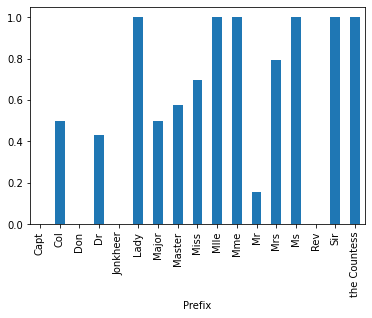

In [8]:
train_df.groupby('Prefix').mean()['Survived'].plot.bar()

In [32]:
def pre_process(df):
    columns  = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'Sex', 'Embarked', 'Surname', 'Prefix', 'Firstname', 
                'Cabin_L', 'Cabin_N',
                'Ticket_C', 'Ticket_N', 'Ticket_Level']
    cat_cols = ['Pclass', 'Sex', 'Surname', 'Prefix', 'Embarked', 'Firstname', 'Cabin_L', 'Cabin_N', 'Ticket_C', 'Ticket_N', 'Ticket_Level']
    X = df[columns]
    y = None
    if 'Survived' in df.columns:
        y = df.Survived
    for c in cat_cols:#X.columns:
        #col_type = X[c].dtype
        #if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')

    return X, y

In [33]:
X_train, y_train = pre_process(train_df)
X_test           = pre_process(test_df)

<ipython-input-32-757a38366e26>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c] = X[c].astype('category')


In [34]:
Counter(y_train)

Counter({0: 549, 1: 342})

In [35]:
lgb = lightgbm.LGBMClassifier()

In [36]:
lgb.fit(X_train, y_train)

LGBMClassifier()

In [37]:
predicted_y = lgb.predict(X_train)


In [38]:
from sklearn.metrics import r2_score, mean_squared_log_error, confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

In [39]:
print(classification_report(y_train, predicted_y))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       549
           1       0.99      0.95      0.97       342

    accuracy                           0.98       891
   macro avg       0.98      0.97      0.98       891
weighted avg       0.98      0.98      0.98       891



In [17]:
print(confusion_matrix(y_train, predicted_y))

[[545   4]
 [ 17 325]]


In [40]:
print(confusion_matrix(y_train, predicted_y))

[[546   3]
 [ 17 325]]


In [41]:
probs = lgb.predict_proba(X_train)

In [42]:
fpr, tpr, thresholds = roc_curve(y_train, probs[:,1])

In [43]:
import matplotlib.pyplot as plt

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.997


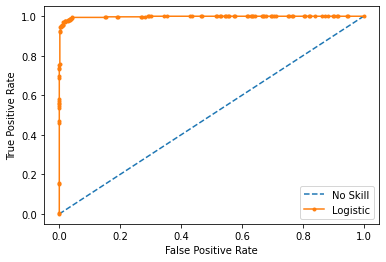

In [44]:
ns_probs = [0 for _ in range(len(y_train))]
lr_probs = probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_train, ns_probs)
lr_auc = roc_auc_score(y_train, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_train, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()